In [107]:
# !pip install tensorflow-gpu==2.0.0

In [108]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import glob
import os

In [109]:
# os.listdir('../input/cat-and-dog/training_set/training_set/')

In [110]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.1.0


In [111]:
# 本地图片的位置
# '../input/dc_2000/train/*/*.jpg'

train_image_path = glob.glob('../input/cat-and-dog/training_set/training_set/*/*.jpg')

len(train_image_path)# kaggle上8005张图片
train_image_path[-5:]

['../input/cat-and-dog/training_set/training_set/dogs/dog.1308.jpg',
 '../input/cat-and-dog/training_set/training_set/dogs/dog.546.jpg',
 '../input/cat-and-dog/training_set/training_set/dogs/dog.1571.jpg',
 '../input/cat-and-dog/training_set/training_set/dogs/dog.1779.jpg',
 '../input/cat-and-dog/training_set/training_set/dogs/dog.783.jpg']

In [112]:
np.random.shuffle(train_image_path) # 打乱路径, 前面几千张全是狗， 后面的全是猫

In [113]:
# 本地数据集读取标签
# train_image_label = [int(path.split('input/dc_2000/train/')[0].split('\\')[1].split('.')[0] == 'cat') for path in train_image_path]

# kaggle上的数据集读取标签
# ../input/cat-and-dog/training_set/training_set/cats/cat.2853.jpg
train_image_label = [int(path.split('/training_set/training_set/')[1].split('/')[1].split('.')[0] == 'cat') for path in train_image_path]
train_image_label[-5:]

[1, 0, 0, 1, 1]

In [114]:
# 查看读取到的图片是否正确
# image = tf.io.read_file(train_image_path[0])
# image = tf.image.decode_jpeg(image, channels=3)
# print(image.shape)
# plt.imshow(image)

In [141]:
def load_preprocess_image(path, label):
    '''
    func:根据路径载入图像和label
    '''


    image = tf.io.read_file(path)   # 根据文件路径读取文件
    image = tf.image.decode_jpeg(image,channels=3) # jpg解码
    image = tf.image.resize(image, [320, 320]) # 统一大小
    
    image = tf.image.random_crop(image, [256, 256, 3])
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, 0.5)
#     image = tf.image.random_contrast(image, 0, 1)
    image = tf.cast(image, tf.float32)  # 转换数据类型
    image = image/255   # 统一数据范围

    label = tf.reshape(label, (1,)) # reshape成(num,)
    return image, label

In [142]:
def load_preprocess_test_image(path, label):
    '''
    func:根据路径载入图像和label
    '''


    image = tf.io.read_file(path)   # 根据文件路径读取文件
    image = tf.image.decode_jpeg(image,channels=3) # jpg解码
    image = tf.image.resize(image, [256, 256]) # 统一大小
    
#    image = tf.image.random_crop(image, [256, 256, 3])
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
#     image = tf.image.random_brightness(image, 0.5)
#     image = tf.image.random_contrast(image, 0, 1)
    image = tf.cast(image, tf.float32)  # 转换数据类型
    image = image/255   # 统一数据范围

    label = tf.reshape(label, (1,)) # reshape成(num,)
    return image, label

In [143]:
#tf.image.convert_image_dtype

In [144]:
train_image_ds = tf.data.Dataset.from_tensor_slices((train_image_path, train_image_label)) # load数据集
# train_image_ds

In [145]:
# 根据计算机的特征，自动的使用并行运算
AUTOTUNE = tf.data.experimental.AUTOTUNE
# AUTOTUNE

In [146]:
# 预处理
train_image_ds = train_image_ds.map(load_preprocess_image, num_parallel_calls=AUTOTUNE) # 载入图像
# print(train_image_ds)

In [147]:
# for img, label in train_image_ds.take(1):
#     plt.imshow(img)

In [148]:
# 设定batch
BATCH_SIZE = 32
train_count = len(train_image_path) # 训练数据集的个数

In [149]:
# 设立batch, train_image_ds是一个可迭代对象
train_image_ds = train_image_ds.shuffle(500).batch(BATCH_SIZE)
train_image_ds = train_image_ds.prefetch(AUTOTUNE)

In [150]:
# imgs,labels=next(iter(train_image_ds))
# imgs.shape
# imgs[0]

In [151]:
# train_image_path = glob.glob('../input/dc_2000/train/*/*.jpg')
# train_image_label = [int(path.split('input/dc_2000/train/')[0].split('\\')[1].split('.')[0] == 'cat') for path in train_image_path]
# test_image_path = glob.glob('../input/dc_2000/test/*/*.jpg')
# test_image_label = [int(path.split('input/dc_2000/train/')[0].split('\\')[0].split('.')[0] == 'cat') for path in test_image_path]

# train_image_path = glob.glob('../input/cat-and-dog/training_set/training_set/*/*.jpg')
test_image_path = glob.glob('../input/cat-and-dog/test_set/test_set/*/*.jpg')
# train_image_label = [int(path.split('/training_set/training_set/')[1].split('/')[1].split('.')[0] == 'cat') for path in train_image_path]
test_image_label = [int(path.split('/test_set/test_set/')[1].split('/')[1].split('.')[0] == 'cat') for path in test_image_path]

# 载入测试图片
test_image_ds = tf.data.Dataset.from_tensor_slices((test_image_path, test_image_label))
test_image_ds = test_image_ds.map(load_preprocess_test_image, num_parallel_calls=AUTOTUNE)
test_image_ds = test_image_ds.batch(BATCH_SIZE)
test_image_ds = test_image_ds.prefetch(AUTOTUNE)

In [152]:
len(test_image_path)

2023

In [153]:
model = keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'),
# #     tf.keras.layers.BatchNormalization(),
#     
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
#     
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
# #     tf.keras.layers.BatchNormalization(),
#     
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
#     
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
# #     tf.keras.layers.BatchNormalization(),
#     
#     tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    
#     tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    
    tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

In [154]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 254, 254, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 127, 127, 64)      0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 125, 125, 128)     73856     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 28, 28, 512)      

In [155]:
# tf.keras.losses.binary_crossentropy([0.,0.,1.,1.], [1.,1.,1.,1.])#二元交叉熵定义loss

In [156]:
# [https://www.jianshu.com/p/aebcaf8af76e]
# 使用Adam优化, 具体一些的对Adam的解释可以看上面的博客
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [157]:
epoch_loss_avg = tf.keras.metrics.Mean('train_loss') # 
train_accuracy = tf.keras.metrics.Accuracy() # 计算正确率

epoch_loss_avg_test = tf.keras.metrics.Mean('test_loss')
test_accuracy = tf.keras.metrics.Accuracy()

In [158]:
# train_accuracy([1,0,1], [1,1,1])

In [159]:
def train_step(model, images, labels):
    """
    func:训练集求梯度
    """
    with tf.GradientTape() as t:
        pred = model(images) # 使用模型预测结果
        loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred) # 计算损失值
    
    grads = t.gradient(loss_step, model.trainable_variables) #计算dloss/d(参数)
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) #根据dloss/d(variable)进行优化

    epoch_loss_avg(loss_step)# 计算loss的均值
    train_accuracy(labels, tf.cast(pred>0, tf.int32))# 计算精确度

In [160]:
def test_step(model, images, labels):
    pred = model(images, training=False)
    loss_step = tf.keras.losses.BinaryCrossentropy(from_logits=True)(labels, pred)
    epoch_loss_avg_test(loss_step)
    test_accuracy(labels, tf.cast(pred>0, tf.int32))

In [161]:
train_loss_results = []
train_acc_results = []

test_loss_results = []
test_acc_results = []

In [162]:
num_epochs = 30

In [163]:
for epoch in range(num_epochs):
#     print(train_image_ds)
    for imgs_, labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        print('.', end='')
    print()
    
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_results.append(train_accuracy.result())
    
    
    for imgs_, labels_ in test_image_ds:
        test_step(model, imgs_, labels_)
        
    test_loss_results.append(epoch_loss_avg_test.result())
    test_acc_results.append(test_accuracy.result())
    
    print('Epoch:{}: loss: {:.3f}, accuracy: {:.3f}, test_loss: {:.3f}, test_accuracy: {:.3f}'.format(
        epoch + 1,
        epoch_loss_avg.result(),
        train_accuracy.result(),
        epoch_loss_avg_test.result(),
        test_accuracy.result()
    ))
    
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

...........................................................................................................................................................................................................................................................
Epoch:1: loss: 0.687, accuracy: 0.536, test_loss: 0.681, test_accuracy: 0.540
...........................................................................................................................................................................................................................................................
Epoch:2: loss: 0.638, accuracy: 0.639, test_loss: 0.630, test_accuracy: 0.651
...........................................................................................................................................................................................................................................................
Epoch:3: loss: 0.602, accuracy: 0.677, test_loss: 0.583, test_accuracy: 0.697
..........

...........................................................................................................................................................................................................................................................
Epoch:26: loss: 0.221, accuracy: 0.913, test_loss: 0.485, test_accuracy: 0.823
...........................................................................................................................................................................................................................................................
Epoch:27: loss: 0.227, accuracy: 0.908, test_loss: 0.284, test_accuracy: 0.882
...........................................................................................................................................................................................................................................................
Epoch:28: loss: 0.209, accuracy: 0.916, test_loss: 0.269, test_accuracy: 0.885
.......

30
30


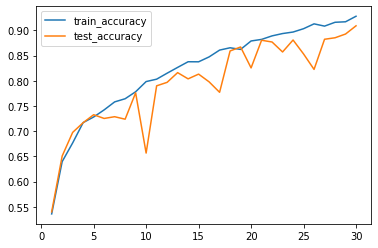

In [164]:
print(len(train_acc_results))
print(len(test_acc_results))
plt.plot(range(1,num_epochs+1),train_acc_results,label='train_accuracy')
plt.plot(range(1,num_epochs+1),test_acc_results,label='test_accuracy')
plt.legend()

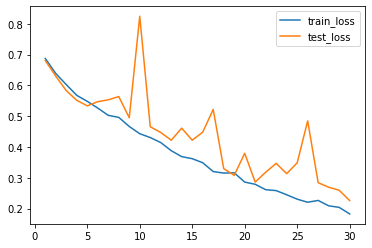

In [165]:
plt.plot(range(1,num_epochs+1),train_loss_results,label='train_loss')
plt.plot(range(1,num_epochs+1),test_loss_results,label='test_loss')
plt.legend()

In [166]:
for epoch in range(num_epochs+1,40):
#     print(train_image_ds)
    for imgs_, labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        print('.', end='')
    print()
    
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_results.append(train_accuracy.result())
    
    
    for imgs_, labels_ in test_image_ds:
        test_step(model, imgs_, labels_)
        
    test_loss_results.append(epoch_loss_avg_test.result())
    test_acc_results.append(test_accuracy.result())
    
    print('Epoch:{}: loss: {:.3f}, accuracy: {:.3f}, test_loss: {:.3f}, test_accuracy: {:.3f}'.format(
        epoch + 1,
        epoch_loss_avg.result(),
        train_accuracy.result(),
        epoch_loss_avg_test.result(),
        test_accuracy.result()
    ))
    
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

...........................................................................................................................................................................................................................................................
Epoch:32: loss: 0.193, accuracy: 0.920, test_loss: 0.243, test_accuracy: 0.901
...........................................................................................................................................................................................................................................................
Epoch:33: loss: 0.177, accuracy: 0.932, test_loss: 0.269, test_accuracy: 0.897
...........................................................................................................................................................................................................................................................
Epoch:34: loss: 0.173, accuracy: 0.932, test_loss: 0.291, test_accuracy: 0.888
.......

39
39


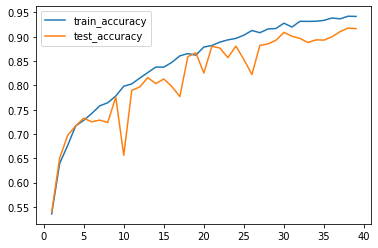

In [169]:
print(len(train_acc_results))
print(len(test_acc_results))
plt.plot(range(1,num_epochs+10),train_acc_results,label='train_accuracy')
plt.plot(range(1,num_epochs+10),test_acc_results,label='test_accuracy')
plt.legend()

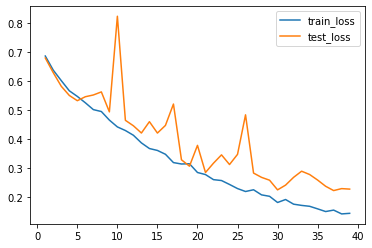

In [170]:
plt.plot(range(1,num_epochs+10),train_loss_results,label='train_loss')
plt.plot(range(1,num_epochs+10),test_loss_results,label='test_loss')
plt.legend()

In [ ]:
for epoch in range(40,51):
#     print(train_image_ds)
    for imgs_, labels_ in train_image_ds:
        train_step(model, imgs_, labels_)
        print('.', end='')
    print()
    
    train_loss_results.append(epoch_loss_avg.result())
    train_acc_results.append(train_accuracy.result())
    
    
    for imgs_, labels_ in test_image_ds:
        test_step(model, imgs_, labels_)
        
    test_loss_results.append(epoch_loss_avg_test.result())
    test_acc_results.append(test_accuracy.result())
    
    print('Epoch:{}: loss: {:.3f}, accuracy: {:.3f}, test_loss: {:.3f}, test_accuracy: {:.3f}'.format(
        epoch + 1,
        epoch_loss_avg.result(),
        train_accuracy.result(),
        epoch_loss_avg_test.result(),
        test_accuracy.result()
    ))
    
    epoch_loss_avg.reset_states()
    train_accuracy.reset_states()
    
    epoch_loss_avg_test.reset_states()
    test_accuracy.reset_states()

...........................................................................................................................................................................................................................................................
Epoch:41: loss: 0.144, accuracy: 0.942, test_loss: 0.204, test_accuracy: 0.922
...........................................................................................................................................................................................................................................................
Epoch:42: loss: 0.136, accuracy: 0.946, test_loss: 0.306, test_accuracy: 0.894
...........................................................................................................................................................................................................................................................
Epoch:43: loss: 0.132, accuracy: 0.947, test_loss: 0.240, test_accuracy: 0.913
.......

...........................................................................................................................................................................................................................................................
Epoch:41: loss: 0.144, accuracy: 0.942, test_loss: 0.204, test_accuracy: 0.922
...........................................................................................................................................................................................................................................................
Epoch:42: loss: 0.136, accuracy: 0.946, test_loss: 0.306, test_accuracy: 0.894
...........................................................................................................................................................................................................................................................
Epoch:43: loss: 0.132, accuracy: 0.947, test_loss: 0.240, test_accuracy: 0.913
...........................................................................................................................................................................................................................................................
Epoch:44: loss: 0.120, accuracy: 0.951, test_loss: 0.209, test_accuracy: 0.919
...........................................................................................................................................................................................................................................................
Epoch:45: loss: 0.114, accuracy: 0.955, test_loss: 0.238, test_accuracy: 0.910
...........................................................................................................................................................................................................................................................
Epoch:46: loss: 0.111, accuracy: 0.958, test_loss: 0.300, test_accuracy: 0.905
...........................................................................................................................................................................................................................................................
Epoch:47: loss: 0.103, accuracy: 0.959, test_loss: 0.221, test_accuracy: 0.922
...........................................................................................................................................................................................................................................................
Epoch:48: loss: 0.112, accuracy: 0.957, test_loss: 0.247, test_accuracy: 0.916
...........................................................................................................................................................................................................................................................
Epoch:49: loss: 0.109, accuracy: 0.958, test_loss: 0.244, test_accuracy: 0.918
...........................................................................................................................................................................................................................................................
Epoch:50: loss: 0.102, accuracy: 0.963, test_loss: 0.218, test_accuracy: 0.924
...........................................................................................................................................................................................................................................................
Epoch:51: loss: 0.094, accuracy: 0.966, test_loss: 0.266, test_accuracy: 0.908

In [ ]:
print(len(train_acc_results))
print(len(test_acc_results))
plt.plot(range(1,len(train_acc_results)+1),train_acc_results,label='train_accuracy')
plt.plot(range(1,len(test_acc_results)+1),test_acc_results,label='test_accuracy')
plt.legend()

In [ ]:
plt.plot(range(1,len(train_acc_results)+1),train_loss_results,label='train_loss')
plt.plot(range(1,len(test_acc_results)+1),test_loss_results,label='test_loss')
plt.legend()